# 🔧 Phase 2 – Feature Engineering
**Objective:**  
Transform unstructured text data into structured numerical features for employee-project matching.

---

## ✅ Steps:
1. Import Libraries & Load Cleaned Data  
2. Build Skills Vocabulary  
3. Extract Employee Skills  
4. Extract Project Skills  
5. Vectorize (Binary + TF-IDF)  
6. Export Feature Matrices


In [34]:
# ================================================
# 1. Import Advanced Libraries for Feature Engineering
# ================================================
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
import os
from pathlib import Path

# Set visualization styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Ensure output directories exist
os.makedirs("../reports/eda_plots", exist_ok=True)
os.makedirs("../model", exist_ok=True)

# File paths for cleaned data
EMP_PATH = "../data/processed/employee_master_cleaned.csv"
EXP_PATH = "../data/processed/employee_experience_cleaned.csv"
PROJ_PATH = "../data/processed/client_projects_cleaned.csv"

def load_cleaned_data():
    """
    Load cleaned datasets with error handling
    Returns: tuple of cleaned dataframes
    """
    try:
        df_emp = pd.read_csv(EMP_PATH)
        df_exp = pd.read_csv(EXP_PATH)
        df_proj = pd.read_csv(PROJ_PATH)
        
        print("✅ Cleaned datasets loaded successfully!")
        print(f"   📊 Employees: {df_emp.shape}")
        print(f"   📊 Experience: {df_exp.shape}")
        print(f"   📊 Projects: {df_proj.shape}")
        
        return df_emp, df_exp, df_proj
        
    except FileNotFoundError as e:
        print(f"❌ Error loading datasets: {e}")
        print("💡 Please run the data cleaning notebook first!")
        return None, None, None

# Load data
df_emp, df_exp, df_proj = load_cleaned_data()

✅ Cleaned datasets loaded successfully!
   📊 Employees: (1000, 6)
   📊 Experience: (1000, 2)
   📊 Projects: (100, 6)


In [35]:
df_emp.head()

,Employee_ID,Name,Department,Years_Experience,Current_Project_ID,Location
0,E101,Mariah Brennan,AI Research,14.5,NaN,Pune
1,E102,Thomas Terry,DevOps,2.2,NaN,Pune
2,E103,Vanessa Jackson MD,Full Stack Dev,3.9,NaN,Mumbai
3,E104,Lori Sanchez,AI Research,8.3,NaN,Chennai
4,E105,Nicole Warner,Data Science,6.0,NaN,Mumbai


🔍 Building comprehensive skills vocabulary...
📋 Extracted 58 unique skills from projects
🔧 Extracted 127 unique skills from employee experience
🎯 Final unified vocabulary: 162 unique skills


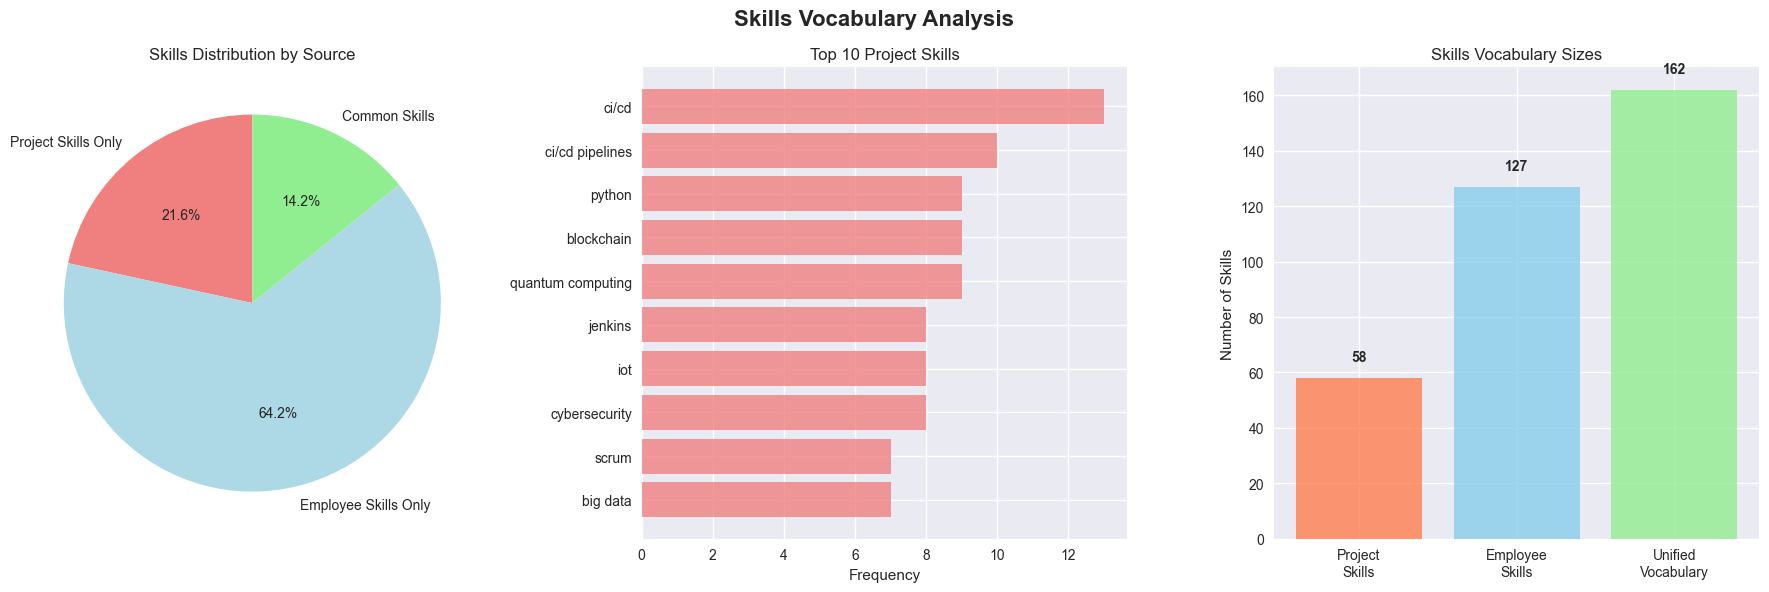


✅ Skills vocabulary created with 162 unique technical skills
✅ Visualization saved to ../reports/eda_plots/skills_vocabulary_analysis.png


In [36]:
# ================================================
# 2. Advanced Skills Vocabulary Building
# ================================================

def extract_project_skills(df_proj):
    """
    Extract comprehensive skills vocabulary from project requirements
    Args: df_proj - project dataframe
    Returns: set of unique project skills
    """
    project_skills_set = set()
    
    for skills_str in df_proj["Required_Skills"].dropna():
        # Split by comma and clean each skill
        skills = [skill.strip().lower() for skill in skills_str.split(",")]
        project_skills_set.update(skills)
    
    print(f"📋 Extracted {len(project_skills_set)} unique skills from projects")
    return project_skills_set

def extract_employee_skills(df_exp):
    """
    Extract skills from employee experience using advanced text processing
    Args: df_exp - experience dataframe
    Returns: set of unique employee skills
    """
    employee_skills_set = set()
    
    # Enhanced regex pattern for technical terms
    skill_pattern = r"[a-zA-Z0-9\+\#\.\-]{2,}"
    
    for text in df_exp["Experience_Text"].dropna():
        # Extract potential technical terms
        tokens = re.findall(skill_pattern, text.lower())
        
        # Filter out common non-technical words
        stop_words = {
            'worked', 'on', 'projects', 'involving', 'delivered', 'solutions', 
            'for', 'domain', 'and', 'the', 'with', 'using', 'in', 'to', 'of',
            'a', 'an', 'is', 'are', 'was', 'were', 'been', 'have', 'has', 'had'
        }
        
        technical_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        employee_skills_set.update(technical_tokens)
    
    print(f"🔧 Extracted {len(employee_skills_set)} unique skills from employee experience")
    return employee_skills_set

def create_unified_skills_vocabulary(project_skills, employee_skills):
    """
    Create unified and cleaned skills vocabulary
    Args: project_skills, employee_skills - skill sets
    Returns: cleaned and sorted skills vocabulary
    """
    # Combine both sets
    all_skills = project_skills.union(employee_skills)
    
    # Clean skill names
    def clean_skill_name(skill):
        """Clean and standardize skill names"""
        cleaned = skill.strip().lower()
        # Remove trailing punctuation
        cleaned = re.sub(r'[^\w\s\-\+\#\.]', '', cleaned)
        # Handle special cases
        cleaned = cleaned.replace('dot net', '.net')
        return cleaned
    
    skills_vocab_cleaned = [clean_skill_name(skill) for skill in all_skills]
    skills_vocab_cleaned = sorted(set(filter(None, skills_vocab_cleaned)))
    
    print(f"🎯 Final unified vocabulary: {len(skills_vocab_cleaned)} unique skills")
    return skills_vocab_cleaned

def visualize_skills_distribution(project_skills, employee_skills, unified_skills):
    """Create visualization of skills distribution"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Skills Vocabulary Analysis", fontsize=16, fontweight='bold')
    
    # Skills source distribution
    sources = ['Project Skills Only', 'Employee Skills Only', 'Common Skills']
    counts = [
        len(project_skills - employee_skills),
        len(employee_skills - project_skills), 
        len(project_skills.intersection(employee_skills))
    ]
    
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    axes[0].pie(counts, labels=sources, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0].set_title('Skills Distribution by Source')
    
    # Top skills from projects
    if df_proj is not None:
        project_skill_counts = Counter()
        for skills_str in df_proj["Required_Skills"].dropna():
            skills = [skill.strip().lower() for skill in skills_str.split(",")]
            project_skill_counts.update(skills)
        
        top_project_skills = dict(project_skill_counts.most_common(10))
        axes[1].barh(list(top_project_skills.keys())[::-1], 
                     list(top_project_skills.values())[::-1], color='lightcoral', alpha=0.8)
        axes[1].set_title('Top 10 Project Skills')
        axes[1].set_xlabel('Frequency')
    
    # Vocabulary size comparison
    vocab_sizes = [len(project_skills), len(employee_skills), len(unified_skills)]
    vocab_labels = ['Project\nSkills', 'Employee\nSkills', 'Unified\nVocabulary']
    
    bars = axes[2].bar(vocab_labels, vocab_sizes, color=['coral', 'skyblue', 'lightgreen'], alpha=0.8)
    axes[2].set_title('Skills Vocabulary Sizes')
    axes[2].set_ylabel('Number of Skills')
    
    # Add value labels on bars
    for bar, size in zip(bars, vocab_sizes):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    str(size), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/skills_vocabulary_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Extract skills from both sources
print("🔍 Building comprehensive skills vocabulary...")

project_skills_set = extract_project_skills(df_proj)
employee_skills_set = extract_employee_skills(df_exp)

# Create unified vocabulary
skills_vocab = create_unified_skills_vocabulary(project_skills_set, employee_skills_set)

# Create visualization
visualize_skills_distribution(project_skills_set, employee_skills_set, skills_vocab)

print(f"\n✅ Skills vocabulary created with {len(skills_vocab)} unique technical skills")
print("✅ Visualization saved to ../reports/eda_plots/skills_vocabulary_analysis.png")

In [37]:
len(project_skills_set), len(employee_skills_set), len(skills_vocab)

(58, 127, 162)

🎯 Applying advanced skills extraction...
✅ Skills extracted for 1000 employees
✅ Skills extracted for 100 projects

📋 Enhanced Data Preview:

--- Employee Experience with Skills ---


,Employee_ID,Experience_Text,Extracted_Skills
0,E101,"Worked on projects involving Azure, Blockchain...","[azure, blockchain, microservices., finance, d..."
1,E102,"Worked on projects involving REST APIs, Data E...","[rest, apis, data, engineering, devops, practi..."
2,E103,Worked on projects involving Data Visualizatio...,"[data, visualization, penetration, testing, de..."
3,E104,"Worked on projects involving GraphQL, Agile, a...","[graphql, agile, java., retail, domain.]"
4,E105,"Worked on projects involving Java, Azure, and ...","[java, azure, data, lake, implementation., ret..."



--- Projects with Skills ---


,Project_ID,Client_Name,Required_Skills,Skill_List
0,P301,Byrd Ltd,"SQL Database Management, Docker, NoSQL","[sql database management, docker, nosql]"
1,P302,"Cunningham, Anderson and Fernandez","Cloud Security, Container Orchestration, Python","[cloud security, container orchestration, python]"
2,P303,"Mata, Mclean and Jones","React, Mobile Development, Microservices Archi...","[react, mobile development, microservices arch..."
3,P304,Rodriguez-Dominguez,"Edge Computing, Jenkins, IoT","[edge computing, jenkins, iot]"
4,P305,Medina-Maldonado,"Terraform, SQL Database Management, NLP","[terraform, sql database management, nlp]"


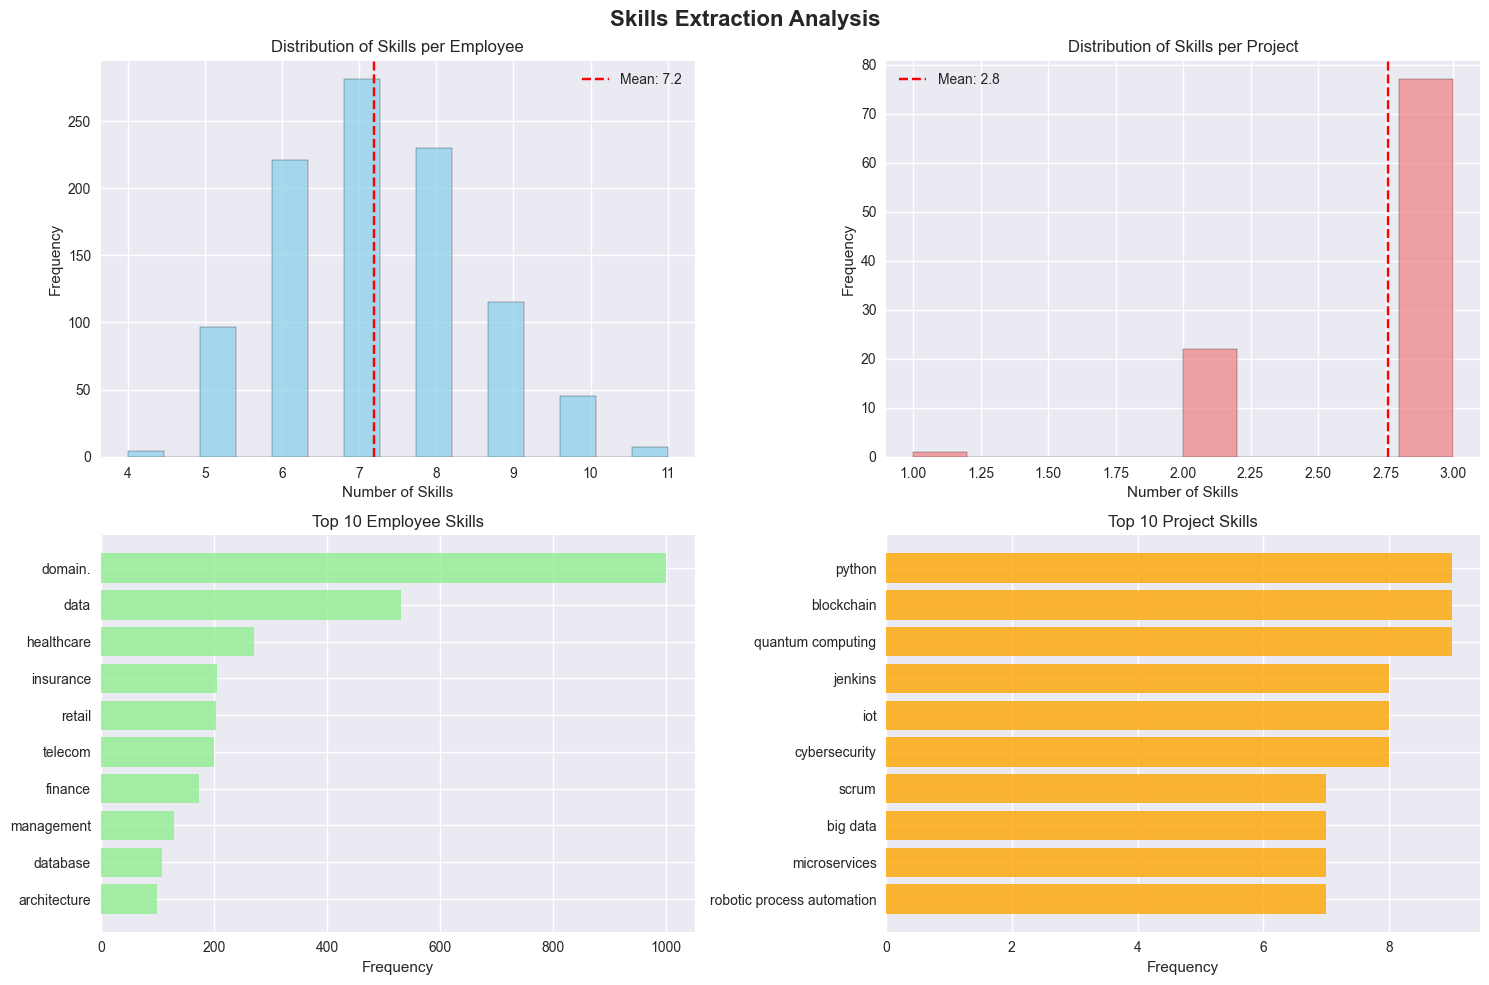


✅ Skills extraction completed successfully!
✅ Visualization saved to ../reports/eda_plots/skills_extraction_analysis.png


In [38]:
# ================================================
# 3. Advanced Skills Extraction per Employee & Project
# ================================================

def extract_employee_skills_advanced(df_exp, skills_vocab):
    """
    Extract and normalize skills for each employee using advanced NLP
    Args: df_exp - experience dataframe, skills_vocab - master vocabulary
    Returns: dataframe with extracted skills per employee
    """
    def process_experience_text(text):
        """Process experience text and extract relevant skills"""
        if pd.isna(text):
            return []
        
        text_lower = text.lower()
        # Enhanced tokenization preserving important technical terms
        tokens = re.findall(r"[a-zA-Z0-9\+\#\.\-]+", text_lower)
        
        # Filter tokens to match our vocabulary
        extracted_skills = [token for token in tokens if token in skills_vocab]
        
        return extracted_skills
    
    # Apply skill extraction
    df_exp_enhanced = df_exp.copy()
    df_exp_enhanced["Extracted_Skills"] = df_exp_enhanced["Experience_Text"].apply(process_experience_text)
    
    print(f"✅ Skills extracted for {len(df_exp_enhanced)} employees")
    return df_exp_enhanced

def extract_project_skills_advanced(df_proj, skills_vocab):
    """
    Extract and normalize skills for each project
    Args: df_proj - project dataframe, skills_vocab - master vocabulary  
    Returns: dataframe with extracted skills per project
    """
    def process_required_skills(skills_str):
        """Process required skills string"""
        if pd.isna(skills_str):
            return []
        
        # Split by comma and clean
        skills = [skill.strip().lower() for skill in skills_str.split(",")]
        
        # Filter to match vocabulary
        extracted_skills = [skill for skill in skills if skill in skills_vocab]
        
        return extracted_skills
    
    # Apply skill extraction
    df_proj_enhanced = df_proj.copy()
    df_proj_enhanced["Skill_List"] = df_proj_enhanced["Required_Skills"].apply(process_required_skills)
    
    print(f"✅ Skills extracted for {len(df_proj_enhanced)} projects")
    return df_proj_enhanced

def visualize_skills_extraction(df_exp_enhanced, df_proj_enhanced):
    """Visualize skills extraction results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Skills Extraction Analysis", fontsize=16, fontweight='bold')
    
    # 1. Distribution of skills per employee
    skills_per_employee = df_exp_enhanced["Extracted_Skills"].apply(len)
    axes[0, 0].hist(skills_per_employee, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Skills per Employee')
    axes[0, 0].set_xlabel('Number of Skills')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(skills_per_employee.mean(), color='red', linestyle='--', 
                       label=f'Mean: {skills_per_employee.mean():.1f}')
    axes[0, 0].legend()
    
    # 2. Distribution of skills per project
    skills_per_project = df_proj_enhanced["Skill_List"].apply(len)
    axes[0, 1].hist(skills_per_project, bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Distribution of Skills per Project')
    axes[0, 1].set_xlabel('Number of Skills')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(skills_per_project.mean(), color='red', linestyle='--',
                       label=f'Mean: {skills_per_project.mean():.1f}')
    axes[0, 1].legend()
    
    # 3. Most common employee skills
    all_emp_skills = []
    for skills_list in df_exp_enhanced["Extracted_Skills"]:
        all_emp_skills.extend(skills_list)
    
    emp_skill_counts = Counter(all_emp_skills).most_common(10)
    if emp_skill_counts:
        skills, counts = zip(*emp_skill_counts)
        axes[1, 0].barh(skills[::-1], counts[::-1], color='lightgreen', alpha=0.8)
        axes[1, 0].set_title('Top 10 Employee Skills')
        axes[1, 0].set_xlabel('Frequency')
    
    # 4. Most common project skills
    all_proj_skills = []
    for skills_list in df_proj_enhanced["Skill_List"]:
        all_proj_skills.extend(skills_list)
    
    proj_skill_counts = Counter(all_proj_skills).most_common(10)
    if proj_skill_counts:
        skills, counts = zip(*proj_skill_counts)
        axes[1, 1].barh(skills[::-1], counts[::-1], color='orange', alpha=0.8)
        axes[1, 1].set_title('Top 10 Project Skills')
        axes[1, 1].set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/skills_extraction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Apply advanced skills extraction
print("🎯 Applying advanced skills extraction...")

df_exp_enhanced = extract_employee_skills_advanced(df_exp, skills_vocab)
df_proj_enhanced = extract_project_skills_advanced(df_proj, skills_vocab)

# Display enhanced data preview
print("\n📋 Enhanced Data Preview:")
print("\n--- Employee Experience with Skills ---")
display(df_exp_enhanced[['Employee_ID', 'Experience_Text', 'Extracted_Skills']].head())

print("\n--- Projects with Skills ---")
display(df_proj_enhanced[['Project_ID', 'Client_Name', 'Required_Skills', 'Skill_List']].head())

# Create visualization
visualize_skills_extraction(df_exp_enhanced, df_proj_enhanced)

print("\n✅ Skills extraction completed successfully!")
print("✅ Visualization saved to ../reports/eda_plots/skills_extraction_analysis.png")

In [39]:
df_exp.head()

,Employee_ID,Experience_Text
0,E101,"Worked on projects involving Azure, Blockchain..."
1,E102,"Worked on projects involving REST APIs, Data E..."
2,E103,Worked on projects involving Data Visualizatio...
3,E104,"Worked on projects involving GraphQL, Agile, a..."
4,E105,"Worked on projects involving Java, Azure, and ..."


In [40]:
df_proj.head()

,Project_ID,Client_Name,Project_Description,Required_Skills,Location,Status
0,P301,Byrd Ltd,Looking for expertise in SQL Database Manageme...,"SQL Database Management, Docker, NoSQL",Delhi,Closed
1,P302,"Cunningham, Anderson and Fernandez","Looking for expertise in Cloud Security, Conta...","Cloud Security, Container Orchestration, Python",Pune,Open
2,P303,"Mata, Mclean and Jones","Looking for expertise in React, Mobile Develop...","React, Mobile Development, Microservices Archi...",Mumbai,Closed
3,P304,Rodriguez-Dominguez,"Looking for expertise in Edge Computing, Jenki...","Edge Computing, Jenkins, IoT",Chennai,Closed
4,P305,Medina-Maldonado,"Looking for expertise in Terraform, SQL Databa...","Terraform, SQL Database Management, NLP",Mumbai,Open


In [41]:
import nltk
from nltk.corpus import stopwords

# Download stopwords once
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

skills_vocab = [skill for skill in skills_vocab if skill not in stop_words]



[nltk_data] Downloading package stopwords to C:\Users\Suraj
[nltk_data]     Khodade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
len(skills_vocab)

162

🚀 Creating comprehensive feature matrices...
🔢 Creating binary skill matrices...
   ✅ Employee matrix: (1000, 162)
   ✅ Project matrix: (100, 162)
📊 Creating TF-IDF matrices...
   ✅ Employee TF-IDF matrix: (1000, 200)
   ✅ Project TF-IDF matrix: (100, 200)
👤 Creating additional employee features...
   ✅ Employee features: (1000, 11)

📊 Feature Matrix Summary:
   Binary matrices: 162 features
   TF-IDF matrices: 200 features
   Employee features: 11 features


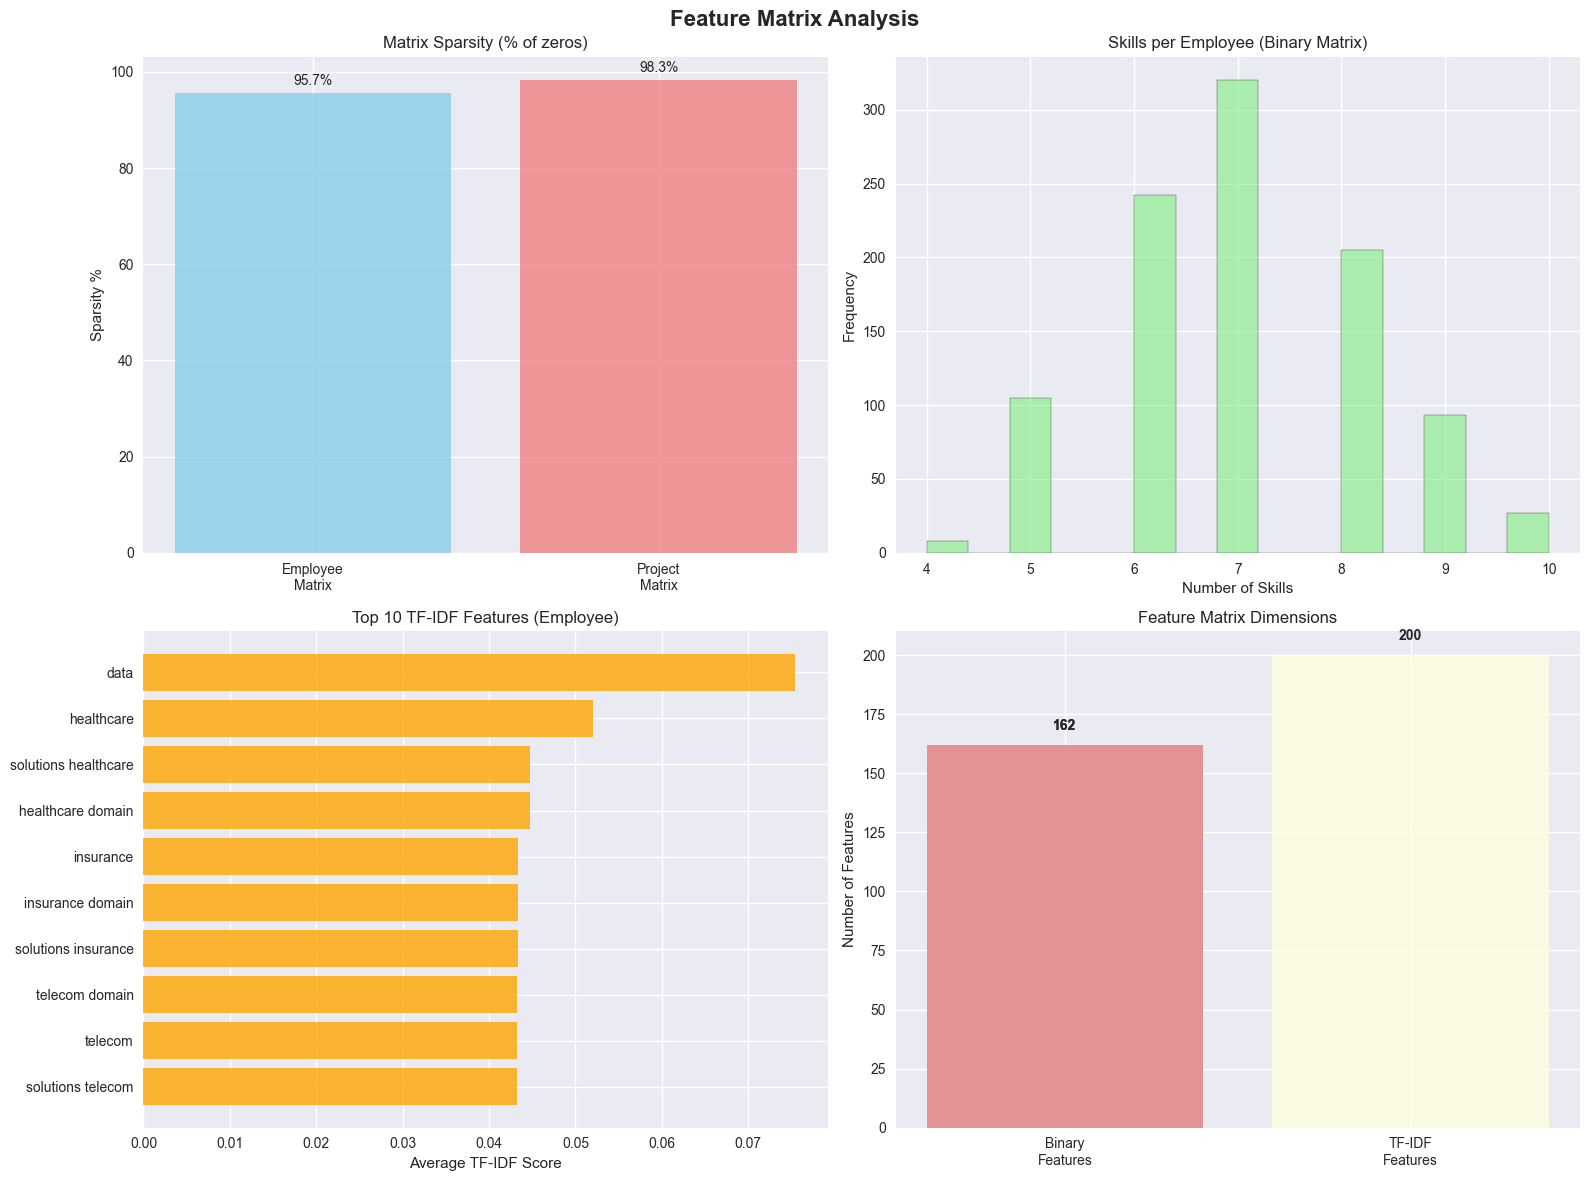


✅ All feature matrices created successfully!
✅ Visualization saved to ../reports/eda_plots/feature_matrices_analysis.png


In [43]:
# ================================================
# 4. Advanced Vectorization (Binary + TF-IDF + Hybrid)
# ================================================

def create_binary_skill_matrices(df_exp_enhanced, df_proj_enhanced, skills_vocab):
    """
    Create binary skill matrices for employees and projects
    Args: enhanced dataframes and skills vocabulary
    Returns: binary matrices for employees and projects
    """
    print("🔢 Creating binary skill matrices...")
    
    # Employee binary matrix
    employee_matrix = pd.DataFrame(0, index=df_exp_enhanced["Employee_ID"], columns=skills_vocab)
    
    for idx, row in df_exp_enhanced.iterrows():
        for skill in row["Extracted_Skills"]:
            if skill in employee_matrix.columns:
                employee_matrix.loc[row["Employee_ID"], skill] = 1
    
    # Project binary matrix
    project_matrix = pd.DataFrame(0, index=df_proj_enhanced["Project_ID"], columns=skills_vocab)
    
    for idx, row in df_proj_enhanced.iterrows():
        for skill in row["Skill_List"]:
            if skill in project_matrix.columns:
                project_matrix.loc[row["Project_ID"], skill] = 1
    
    print(f"   ✅ Employee matrix: {employee_matrix.shape}")
    print(f"   ✅ Project matrix: {project_matrix.shape}")
    
    return employee_matrix, project_matrix

def create_tfidf_matrices(df_exp_enhanced, df_proj_enhanced):
    """
    Create TF-IDF matrices for more nuanced skill representation
    Args: enhanced dataframes
    Returns: TF-IDF matrices
    """
    print("📊 Creating TF-IDF matrices...")
    
    # Prepare text data for TF-IDF
    employee_texts = df_exp_enhanced["Experience_Text"].fillna("")
    project_texts = df_proj_enhanced["Required_Skills"].fillna("")
    
    # Create TF-IDF vectorizer with optimized parameters
    tfidf_vectorizer = TfidfVectorizer(
        max_features=200,  # Limit features for computational efficiency
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Minimum document frequency
        max_df=0.8  # Maximum document frequency
    )
    
    # Fit on combined corpus
    all_texts = list(employee_texts) + list(project_texts)
    tfidf_vectorizer.fit(all_texts)
    
    # Transform employee and project texts
    employee_tfidf = tfidf_vectorizer.transform(employee_texts)
    project_tfidf = tfidf_vectorizer.transform(project_texts)
    
    # Convert to DataFrames
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    employee_tfidf_df = pd.DataFrame(
        employee_tfidf.toarray(), 
        index=df_exp_enhanced["Employee_ID"], 
        columns=feature_names
    )
    
    project_tfidf_df = pd.DataFrame(
        project_tfidf.toarray(),
        index=df_proj_enhanced["Project_ID"],
        columns=feature_names
    )
    
    print(f"   ✅ Employee TF-IDF matrix: {employee_tfidf_df.shape}")
    print(f"   ✅ Project TF-IDF matrix: {project_tfidf_df.shape}")
    
    return employee_tfidf_df, project_tfidf_df, tfidf_vectorizer

def create_employee_features(df_emp):
    """
    Create additional employee features (experience, department, location)
    Args: employee dataframe
    Returns: enhanced feature matrix
    """
    print("👤 Creating additional employee features...")
    
    # Normalize years of experience
    scaler = MinMaxScaler()
    df_emp_features = df_emp.copy()
    df_emp_features["Years_Experience_Norm"] = scaler.fit_transform(df_emp[["Years_Experience"]])
    
    # Create dummy variables for categorical features
    dept_dummies = pd.get_dummies(df_emp["Department"], prefix="Dept")
    location_dummies = pd.get_dummies(df_emp["Location"], prefix="Loc")
    
    # Combine features
    employee_features = pd.concat([
        df_emp_features[["Employee_ID", "Years_Experience_Norm"]], 
        dept_dummies, 
        location_dummies
    ], axis=1)
    
    employee_features.set_index("Employee_ID", inplace=True)
    
    print(f"   ✅ Employee features: {employee_features.shape}")
    return employee_features

def visualize_feature_matrices(employee_matrix, project_matrix, employee_tfidf_df):
    """Visualize the created feature matrices"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Feature Matrix Analysis", fontsize=16, fontweight='bold')
    
    # 1. Binary matrix sparsity
    emp_sparsity = (employee_matrix == 0).sum().sum() / (employee_matrix.shape[0] * employee_matrix.shape[1]) * 100
    proj_sparsity = (project_matrix == 0).sum().sum() / (project_matrix.shape[0] * project_matrix.shape[1]) * 100
    
    sparsity_data = [emp_sparsity, proj_sparsity]
    sparsity_labels = ['Employee\nMatrix', 'Project\nMatrix']
    
    bars = axes[0, 0].bar(sparsity_labels, sparsity_data, color=['skyblue', 'lightcoral'], alpha=0.8)
    axes[0, 0].set_title('Matrix Sparsity (% of zeros)')
    axes[0, 0].set_ylabel('Sparsity %')
    
    for bar, value in zip(bars, sparsity_data):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}%', ha='center', va='bottom')
    
    # 2. Skills per employee distribution
    skills_per_emp = employee_matrix.sum(axis=1)
    axes[0, 1].hist(skills_per_emp, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Skills per Employee (Binary Matrix)')
    axes[0, 1].set_xlabel('Number of Skills')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. TF-IDF feature importance
    feature_importance = employee_tfidf_df.mean().sort_values(ascending=False).head(10)
    axes[1, 0].barh(feature_importance.index[::-1], feature_importance.values[::-1], 
                    color='orange', alpha=0.8)
    axes[1, 0].set_title('Top 10 TF-IDF Features (Employee)')
    axes[1, 0].set_xlabel('Average TF-IDF Score')
    
    # 4. Matrix dimensions comparison
    matrix_dims = [
        employee_matrix.shape[1],
        project_matrix.shape[1], 
        employee_tfidf_df.shape[1]
    ]
    matrix_labels = ['Binary\nFeatures', 'Binary\nFeatures', 'TF-IDF\nFeatures']
    
    bars = axes[1, 1].bar(matrix_labels, matrix_dims, 
                         color=['lightblue', 'lightcoral', 'lightyellow'], alpha=0.8)
    axes[1, 1].set_title('Feature Matrix Dimensions')
    axes[1, 1].set_ylabel('Number of Features')
    
    for bar, dim in zip(bars, matrix_dims):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                       str(dim), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/feature_matrices_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create all feature matrices
print("🚀 Creating comprehensive feature matrices...")

# 1. Binary skill matrices
employee_binary_matrix, project_binary_matrix = create_binary_skill_matrices(
    df_exp_enhanced, df_proj_enhanced, skills_vocab
)

# 2. TF-IDF matrices  
employee_tfidf_matrix, project_tfidf_matrix, tfidf_vectorizer = create_tfidf_matrices(
    df_exp_enhanced, df_proj_enhanced
)

# 3. Additional employee features
employee_features = create_employee_features(df_emp)

# Display matrix summaries
print(f"\n📊 Feature Matrix Summary:")
print(f"   Binary matrices: {len(skills_vocab)} features")
print(f"   TF-IDF matrices: {employee_tfidf_matrix.shape[1]} features")
print(f"   Employee features: {employee_features.shape[1]} features")

# Create visualization
visualize_feature_matrices(employee_binary_matrix, project_binary_matrix, employee_tfidf_matrix)

print("\n✅ All feature matrices created successfully!")
print("✅ Visualization saved to ../reports/eda_plots/feature_matrices_analysis.png")

In [44]:
# Create binary skill matrix for employees
employee_matrix = pd.DataFrame(0, index=df_exp_enhanced["Employee_ID"], columns=skills_vocab)
for idx, row in df_exp_enhanced.iterrows():
    for skill in row["Extracted_Skills"]:
        if skill in employee_matrix.columns:
            employee_matrix.loc[row["Employee_ID"], skill] = 1

# Create binary skill matrix for projects
project_matrix = pd.DataFrame(0, index=df_proj_enhanced["Project_ID"], columns=skills_vocab)
for idx, row in df_proj_enhanced.iterrows():
    for skill in row["Skill_List"]:
        if skill in project_matrix.columns:
            project_matrix.loc[row["Project_ID"], skill] = 1



In [45]:
employee_matrix.head()

,.net,.net.,agile,agile project management,agile.,analytics,analytics.,api,api development,apis,...,tensorflow.,terraform,terraform.,testing,testing.,uiux design,visualization,visualization.,warehousing,warehousing.
Employee_ID,,,,,,,,,,,,,,,,,,,,,
E101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E102,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
E103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
E104,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
project_matrix.head()

,.net,.net.,agile,agile project management,agile.,analytics,analytics.,api,api development,apis,...,tensorflow.,terraform,terraform.,testing,testing.,uiux design,visualization,visualization.,warehousing,warehousing.
Project_ID,,,,,,,,,,,,,,,,,,,,,
P301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P305,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the cleaned skills vocabulary (skills_vocab_cleaned) if you have it,
# otherwise use your current skills_vocab list

# Instantiate TF-IDF vectorizer with predefined vocabulary
vectorizer = TfidfVectorizer(vocabulary=skills_vocab, lowercase=True)

# Fit-transform the Experience_Text column
tfidf_matrix = vectorizer.fit_transform(df_exp["Experience_Text"].fillna(""))

# Convert to DataFrame for easy manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df_exp["Employee_ID"], columns=vectorizer.get_feature_names_out())

print("TF-IDF matrix shape:", tfidf_df.shape)
print(tfidf_df.head())


TF-IDF matrix shape: (1000, 162)
             .net  .net.     agile  agile project management  agile.  \
Employee_ID                                                            
E101          0.0    0.0  0.000000                       0.0     0.0   
E102          0.0    0.0  0.000000                       0.0     0.0   
E103          0.0    0.0  0.000000                       0.0     0.0   
E104          0.0    0.0  0.516225                       0.0     0.0   
E105          0.0    0.0  0.000000                       0.0     0.0   

             analytics  analytics.  api  api development      apis  ...  \
Employee_ID                                                         ...   
E101               0.0         0.0  0.0              0.0  0.000000  ...   
E102               0.0         0.0  0.0              0.0  0.417604  ...   
E103               0.0         0.0  0.0              0.0  0.000000  ...   
E104               0.0         0.0  0.0              0.0  0.000000  ...   
E105        

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_emp["Years_Experience_Norm"] = scaler.fit_transform(df_emp[["Years_Experience"]])

print(df_emp[["Years_Experience", "Years_Experience_Norm"]].head())


   Years_Experience  Years_Experience_Norm
0              14.5               0.971223
1               2.2               0.086331
2               3.9               0.208633
3               8.3               0.525180
4               6.0               0.359712


In [49]:
df_emp_dept = pd.get_dummies(df_emp["Department"], prefix="Dept")
df_emp_loc = pd.get_dummies(df_emp["Location"], prefix="Loc")

# Concatenate with main employee DataFrame
df_emp_features = pd.concat([df_emp[["Employee_ID", "Years_Experience_Norm"]], df_emp_dept, df_emp_loc], axis=1)

df_emp_features.set_index("Employee_ID", inplace=True)
print(df_emp_features.head())


             Years_Experience_Norm  Dept_AI Research  Dept_Cloud Engineering  \
Employee_ID                                                                    
E101                      0.971223              True                   False   
E102                      0.086331             False                   False   
E103                      0.208633             False                   False   
E104                      0.525180              True                   False   
E105                      0.359712             False                   False   

             Dept_Cybersecurity  Dept_Data Science  Dept_DevOps  \
Employee_ID                                                       
E101                      False              False        False   
E102                      False              False         True   
E103                      False              False        False   
E104                      False              False        False   
E105                      False      

🔗 Combining employee features...
   📋 Common employees across all matrices: 1000
   ✅ Combined matrix shape: (1000, 373)
🔍 Validating feature matrices...

📊 Validation Results:

Employee Features:
   Shape: (1000, 373)
   Missing values: 0
   Sparsity: 94.00%

Project Binary:
   Shape: (100, 162)
   Missing values: 0
   Sparsity: 98.30%

Project Tfidf:
   Shape: (100, 200)
   Missing values: 0
   Sparsity: 96.26%

🎯 Combined Employee Features Sample:


,skill_.net,skill_.net.,skill_agile,skill_agile project management,skill_agile.,skill_analytics,skill_analytics.,skill_api,skill_api development,skill_apis,...,Dept_AI Research,Dept_Cloud Engineering,Dept_Cybersecurity,Dept_Data Science,Dept_DevOps,Dept_Full Stack Dev,Loc_Chennai,Loc_Delhi,Loc_Mumbai,Loc_Pune
Employee_ID,,,,,,,,,,,,,,,,,,,,,
E946,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,True,False,False
E153,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,True,False,False,True,False
E679,1,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,True
E319,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,True
E775,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,True,False,False


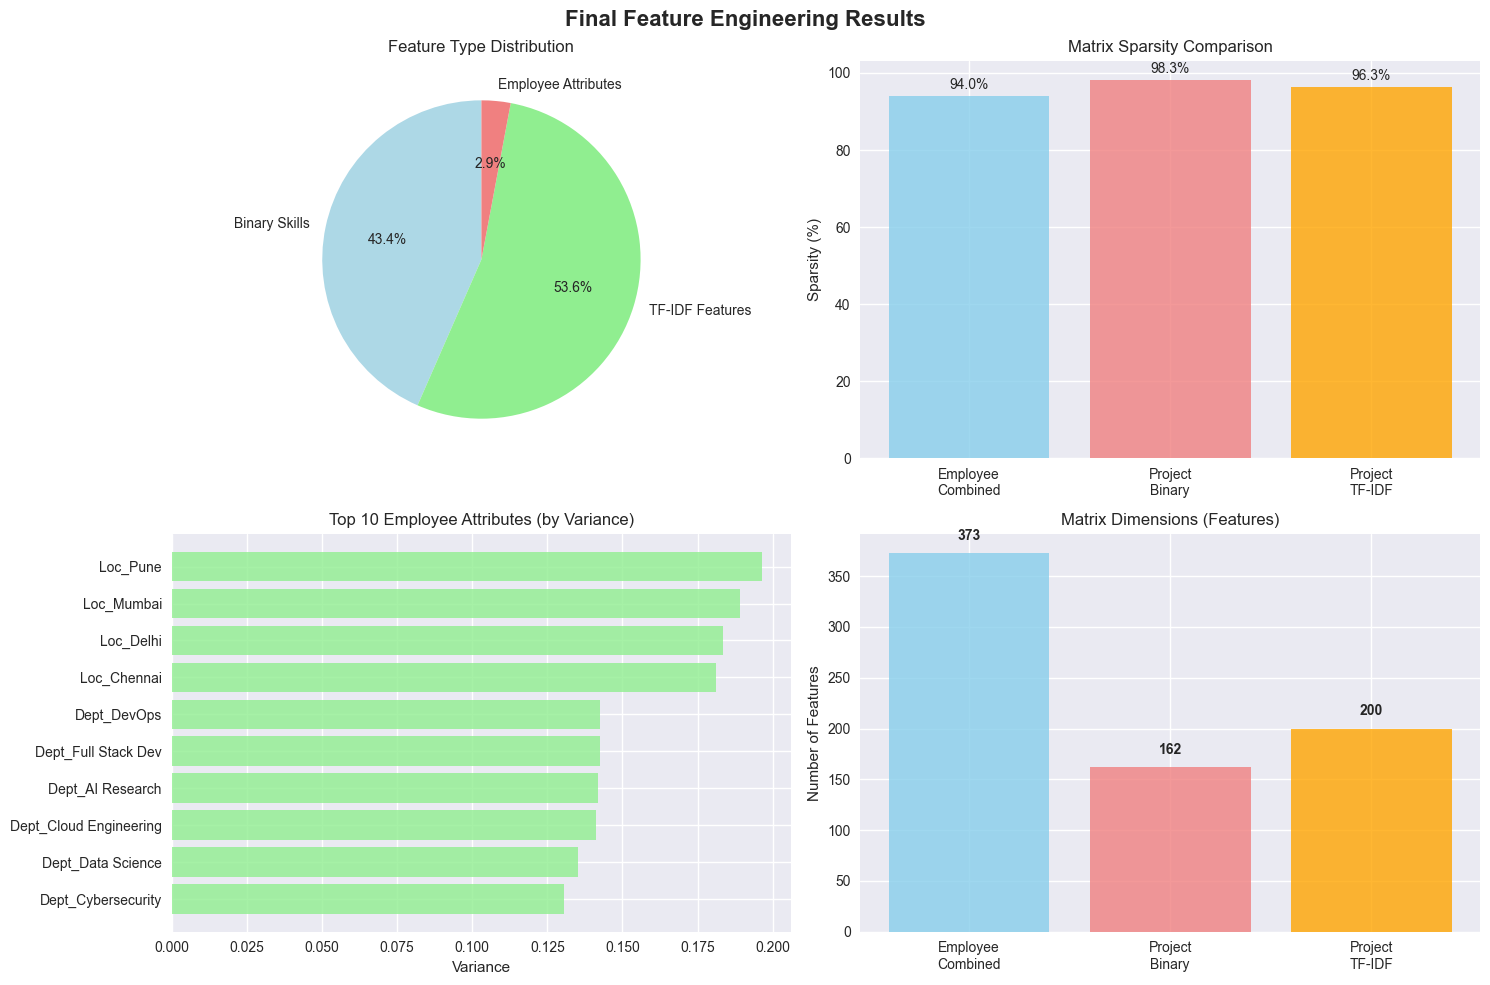


✅ Feature combination completed successfully!
✅ Visualization saved to ../reports/eda_plots/final_feature_engineering.png


In [50]:
# ================================================
# 5. Advanced Feature Combination & Final Matrix Creation  
# ================================================

def create_combined_employee_features(binary_matrix, tfidf_matrix, additional_features):
    """
    Combine different types of features into comprehensive employee representation
    Args: binary_matrix, tfidf_matrix, additional_features
    Returns: combined feature matrix
    """
    print("🔗 Combining employee features...")
    
    # Ensure all matrices have the same index (Employee_ID)
    common_employees = set(binary_matrix.index) & set(tfidf_matrix.index) & set(additional_features.index)
    print(f"   📋 Common employees across all matrices: {len(common_employees)}")
    
    # Align indices
    binary_aligned = binary_matrix.loc[list(common_employees)]
    tfidf_aligned = tfidf_matrix.loc[list(common_employees)] 
    features_aligned = additional_features.loc[list(common_employees)]
    
    # Combine features with prefixes for clarity
    binary_prefixed = binary_aligned.add_prefix('skill_')
    tfidf_prefixed = tfidf_aligned.add_prefix('tfidf_')
    
    # Combine all features
    combined_features = pd.concat([
        binary_prefixed,
        tfidf_prefixed, 
        features_aligned
    ], axis=1)
    
    print(f"   ✅ Combined matrix shape: {combined_features.shape}")
    return combined_features

def validate_feature_matrices(emp_combined, proj_binary, proj_tfidf):
    """
    Validate all feature matrices for consistency and quality
    Args: employee combined matrix, project matrices
    Returns: validation results
    """
    print("🔍 Validating feature matrices...")
    
    validation_results = {
        'employee_features': {
            'shape': emp_combined.shape,
            'missing_values': emp_combined.isnull().sum().sum(),
            'sparsity': (emp_combined == 0).sum().sum() / (emp_combined.shape[0] * emp_combined.shape[1]) * 100
        },
        'project_binary': {
            'shape': proj_binary.shape,
            'missing_values': proj_binary.isnull().sum().sum(),
            'sparsity': (proj_binary == 0).sum().sum() / (proj_binary.shape[0] * proj_binary.shape[1]) * 100
        },
        'project_tfidf': {
            'shape': proj_tfidf.shape,
            'missing_values': proj_tfidf.isnull().sum().sum(),
            'sparsity': (proj_tfidf == 0).sum().sum() / (proj_tfidf.shape[0] * proj_tfidf.shape[1]) * 100
        }
    }
    
    print("\n📊 Validation Results:")
    print("=" * 50)
    for matrix_name, metrics in validation_results.items():
        print(f"\n{matrix_name.replace('_', ' ').title()}:")
        print(f"   Shape: {metrics['shape']}")
        print(f"   Missing values: {metrics['missing_values']}")
        print(f"   Sparsity: {metrics['sparsity']:.2f}%")
    
    return validation_results

def create_final_visualization(emp_combined, validation_results):
    """Create final feature engineering visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Final Feature Engineering Results", fontsize=16, fontweight='bold')
    
    # 1. Feature type distribution in combined matrix
    feature_types = {
        'Binary Skills': len([col for col in emp_combined.columns if col.startswith('skill_')]),
        'TF-IDF Features': len([col for col in emp_combined.columns if col.startswith('tfidf_')]),
        'Employee Attributes': len([col for col in emp_combined.columns if not col.startswith(('skill_', 'tfidf_'))])
    }
    
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    axes[0, 0].pie(feature_types.values(), labels=feature_types.keys(), autopct='%1.1f%%',
                   colors=colors, startangle=90)
    axes[0, 0].set_title('Feature Type Distribution')
    
    # 2. Matrix sparsity comparison
    matrices = ['Employee\nCombined', 'Project\nBinary', 'Project\nTF-IDF']
    sparsities = [
        validation_results['employee_features']['sparsity'],
        validation_results['project_binary']['sparsity'],
        validation_results['project_tfidf']['sparsity']
    ]
    
    bars = axes[0, 1].bar(matrices, sparsities, color=['skyblue', 'lightcoral', 'orange'], alpha=0.8)
    axes[0, 1].set_title('Matrix Sparsity Comparison')
    axes[0, 1].set_ylabel('Sparsity (%)')
    
    for bar, sparsity in zip(bars, sparsities):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{sparsity:.1f}%', ha='center', va='bottom')
    
    # 3. Feature importance (top employee attributes)
    emp_attrs = emp_combined[[col for col in emp_combined.columns if not col.startswith(('skill_', 'tfidf_'))]]
    attr_variance = emp_attrs.var().sort_values(ascending=False).head(10)
    
    axes[1, 0].barh(attr_variance.index[::-1], attr_variance.values[::-1], 
                    color='lightgreen', alpha=0.8)
    axes[1, 0].set_title('Top 10 Employee Attributes (by Variance)')
    axes[1, 0].set_xlabel('Variance')
    
    # 4. Matrix dimensions summary
    dimensions = [
        validation_results['employee_features']['shape'][1],
        validation_results['project_binary']['shape'][1],
        validation_results['project_tfidf']['shape'][1]
    ]
    
    bars = axes[1, 1].bar(matrices, dimensions, color=['skyblue', 'lightcoral', 'orange'], alpha=0.8)
    axes[1, 1].set_title('Matrix Dimensions (Features)')
    axes[1, 1].set_ylabel('Number of Features')
    
    for bar, dim in zip(bars, dimensions):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                       str(dim), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/final_feature_engineering.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create combined employee features
employee_features_combined = create_combined_employee_features(
    employee_binary_matrix, employee_tfidf_matrix, employee_features
)

# Validate all matrices
validation_results = validate_feature_matrices(
    employee_features_combined, project_binary_matrix, project_tfidf_matrix
)

# Display sample of combined features
print("\n🎯 Combined Employee Features Sample:")
display(employee_features_combined.head())

# Create final visualization
create_final_visualization(employee_features_combined, validation_results)

print("\n✅ Feature combination completed successfully!")
print("✅ Visualization saved to ../reports/eda_plots/final_feature_engineering.png")

In [51]:
# ================================================
# 6. Export Feature Matrices & Create Modular Pickle Files
# ================================================

def save_feature_matrices_to_pickle():
    """
    Save all feature matrices as pickle files for modular use
    Returns: success status
    """
    print("💾 Saving feature matrices to pickle files...")
    
    # Dictionary of all matrices to save
    matrices_to_save = {
        'employee_features_combined.pkl': employee_features_combined,
        'employee_binary_matrix.pkl': employee_binary_matrix,
        'employee_tfidf_matrix.pkl': employee_tfidf_matrix,
        'project_binary_matrix.pkl': project_binary_matrix,
        'project_tfidf_matrix.pkl': project_tfidf_matrix,
        'employee_features_basic.pkl': employee_features,
        'skills_vocabulary.pkl': skills_vocab,
        'tfidf_vectorizer.pkl': tfidf_vectorizer
    }
    
    success_count = 0
    
    for filename, data in matrices_to_save.items():
        try:
            filepath = f"../model/{filename}"
            with open(filepath, 'wb') as f:
                pickle.dump(data, f)
            print(f"   ✅ {filename}")
            success_count += 1
        except Exception as e:
            print(f"   ❌ {filename}: {e}")
    
    print(f"\n📊 Successfully saved {success_count}/{len(matrices_to_save)} files")
    return success_count == len(matrices_to_save)

def save_processed_dataframes():
    """Save enhanced dataframes with extracted skills"""
    print("\n💾 Saving enhanced dataframes...")
    
    try:
        # Save enhanced dataframes to processed folder
        df_exp_enhanced.to_csv("../data/processed/employee_experience_enhanced.csv", index=False)
        df_proj_enhanced.to_csv("../data/processed/client_projects_enhanced.csv", index=False)
        
        print("   ✅ employee_experience_enhanced.csv")
        print("   ✅ client_projects_enhanced.csv")
        
        return True
    except Exception as e:
        print(f"   ❌ Error saving dataframes: {e}")
        return False

def create_feature_engineering_summary():
    """Create comprehensive summary of feature engineering process"""
    summary = {
        'Data Processing': {
            'Original Employees': len(df_emp),
            'Original Projects': len(df_proj),
            'Skills Vocabulary Size': len(skills_vocab),
            'Employees with Features': len(employee_features_combined),
            'Projects Processed': len(project_binary_matrix)
        },
        'Feature Matrices': {
            'Employee Binary Features': employee_binary_matrix.shape[1],
            'Employee TF-IDF Features': employee_tfidf_matrix.shape[1],
            'Employee Additional Features': employee_features.shape[1],
            'Employee Combined Features': employee_features_combined.shape[1],
            'Project Binary Features': project_binary_matrix.shape[1],
            'Project TF-IDF Features': project_tfidf_matrix.shape[1]
        },
        'Quality Metrics': {
            'Employee Matrix Sparsity': f"{(employee_features_combined == 0).sum().sum() / (employee_features_combined.shape[0] * employee_features_combined.shape[1]) * 100:.2f}%",
            'Project Binary Sparsity': f"{(project_binary_matrix == 0).sum().sum() / (project_binary_matrix.shape[0] * project_binary_matrix.shape[1]) * 100:.2f}%",
            'Average Skills per Employee': f"{employee_binary_matrix.sum(axis=1).mean():.2f}",
            'Average Skills per Project': f"{project_binary_matrix.sum(axis=1).mean():.2f}"
        }
    }
    
    print("\n📋 FEATURE ENGINEERING SUMMARY REPORT")
    print("=" * 60)
    
    for section, metrics in summary.items():
        print(f"\n{section}:")
        print("-" * 40)
        for metric, value in metrics.items():
            print(f"  {metric}: {value}")
    
    return summary

def create_usage_guide():
    """Create usage guide for the generated pickle files"""
    usage_guide = """
# Feature Matrices Usage Guide

## Available Pickle Files:

1. **employee_features_combined.pkl**: 
   - Complete employee feature matrix (binary + TF-IDF + attributes)
   - Use for: Comprehensive matching algorithms

2. **employee_binary_matrix.pkl**: 
   - Binary skill matrix for employees
   - Use for: Simple skill matching, Jaccard similarity

3. **employee_tfidf_matrix.pkl**: 
   - TF-IDF features from experience text
   - Use for: Semantic similarity, cosine similarity

4. **project_binary_matrix.pkl**: 
   - Binary skill matrix for projects
   - Use for: Direct skill requirement matching

5. **project_tfidf_matrix.pkl**: 
   - TF-IDF features from project descriptions
   - Use for: Semantic project analysis

6. **employee_features_basic.pkl**: 
   - Basic employee attributes (experience, department, location)
   - Use for: Filtering and business rules

7. **skills_vocabulary.pkl**: 
   - Master skills vocabulary list
   - Use for: Skill validation and new data processing

8. **tfidf_vectorizer.pkl**: 
   - Trained TF-IDF vectorizer
   - Use for: Processing new text data

## Loading Example:
```python
import pickle
with open('model/employee_features_combined.pkl', 'rb') as f:
    employee_features = pickle.load(f)
```
"""
    
    with open("../model/README_usage_guide.txt", "w") as f:
        f.write(usage_guide)
    
    print("\n📖 Usage guide created: ../model/README_usage_guide.txt")

# Execute all saving operations
print("🚀 Starting final export process...")

# Save pickle files
pickle_success = save_feature_matrices_to_pickle()

# Save enhanced dataframes
df_success = save_processed_dataframes()

# Create summary report
summary_report = create_feature_engineering_summary()

# Create usage guide
create_usage_guide()

# Final status report
if pickle_success and df_success:
    print(f"\n🎉 FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print(f"✅ All feature matrices saved to ../model/")
    print(f"✅ Enhanced dataframes saved to ../data/processed/")
    print(f"✅ Visualizations saved to ../reports/eda_plots/")
    print(f"✅ Usage guide created in ../model/")
    print(f"\n🚀 Ready for Matching Model phase!")
    
    # Display file structure
    print(f"\n📁 Generated Files Structure:")
    print(f"   📂 model/")
    print(f"      📄 employee_features_combined.pkl")
    print(f"      📄 employee_binary_matrix.pkl") 
    print(f"      📄 project_binary_matrix.pkl")
    print(f"      📄 skills_vocabulary.pkl")
    print(f"      📄 tfidf_vectorizer.pkl")
    print(f"      📄 README_usage_guide.txt")
    print(f"   📂 reports/eda_plots/")
    print(f"      📄 skills_vocabulary_analysis.png")
    print(f"      📄 skills_extraction_analysis.png")
    print(f"      📄 feature_matrices_analysis.png")
    print(f"      📄 final_feature_engineering.png")
    
else:
    print(f"\n⚠️ Some operations failed. Please check the errors above.")

🚀 Starting final export process...
💾 Saving feature matrices to pickle files...
   ✅ employee_features_combined.pkl
   ✅ employee_binary_matrix.pkl
   ✅ employee_tfidf_matrix.pkl
   ✅ project_binary_matrix.pkl
   ✅ project_tfidf_matrix.pkl
   ✅ employee_features_basic.pkl
   ✅ skills_vocabulary.pkl
   ✅ tfidf_vectorizer.pkl

📊 Successfully saved 8/8 files

💾 Saving enhanced dataframes...
   ✅ employee_experience_enhanced.csv
   ✅ client_projects_enhanced.csv

📋 FEATURE ENGINEERING SUMMARY REPORT

Data Processing:
----------------------------------------
  Original Employees: 1000
  Original Projects: 100
  Skills Vocabulary Size: 162
  Employees with Features: 1000
  Projects Processed: 100

Feature Matrices:
----------------------------------------
  Employee Binary Features: 162
  Employee TF-IDF Features: 200
  Employee Additional Features: 11
  Employee Combined Features: 373
  Project Binary Features: 162
  Project TF-IDF Features: 200

Quality Metrics:
---------------------------